In [1]:
import matplotlib
import matplotlib.pyplot as plt
import skimage
import numpy as np
import pandas as pd

In [2]:
from skimage import exposure, io, img_as_float
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.feature_extraction import image
from PIL import Image, ImageEnhance

In [3]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
from skimage.morphology import label
from skimage.measure import regionprops
from skimage import data, util

In [4]:
import matplotlib.patches as mpatches
from random import random

In [5]:
from scipy import ndimage
from scipy.ndimage import find_objects

In [37]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import LinearSVC

In [7]:
img = io.imread("data/Stephanie/hyp-right/Images/10929IBA1_0021_20190610.TIF")
grayscale = rgb2gray(img)

Estimated Gaussian noise standard deviation = 0.12025487874733404


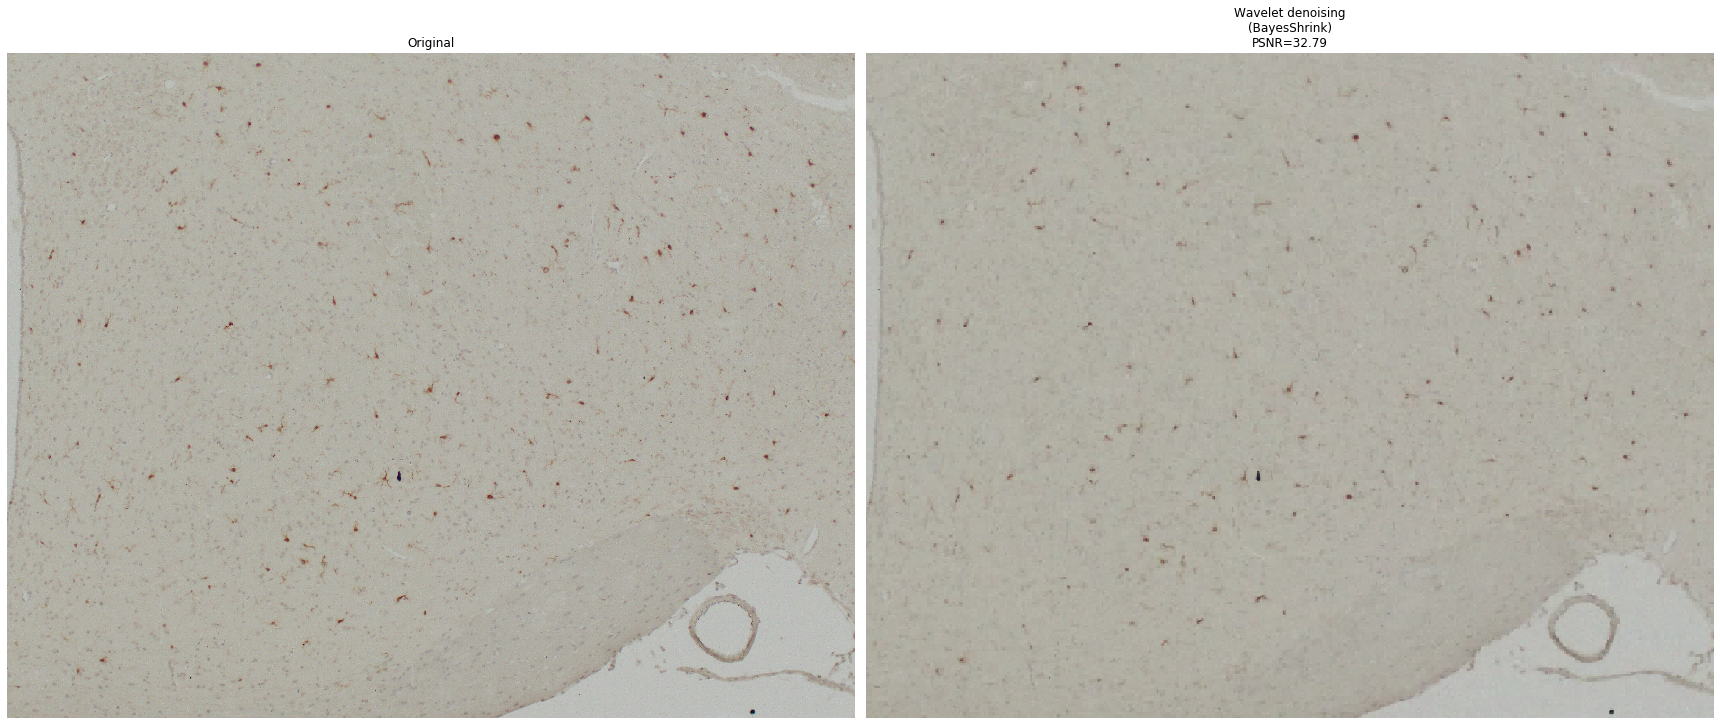

In [8]:
original = img_as_float(img)

sigma = 0.12
noisy = random_noise(original, var=sigma**2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, multichannel=True, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

im_bayes = denoise_wavelet(noisy, multichannel=True, convert2ycbcr=True,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True)

# Compute PSNR as an indication of image quality
psnr_bayes = peak_signal_noise_ratio(original, im_bayes)

ax[1].imshow(im_bayes)
ax[1].axis('off')
ax[1].set_title(
    'Wavelet denoising\n(BayesShrink)\nPSNR={:0.4g}'.format(psnr_bayes))
ax[0].imshow(original)
ax[0].axis('off')
ax[0].set_title('Original')
fig.tight_layout()

plt.show()

In [9]:
grayscale_bayes = rgb2gray(im_bayes)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(im_bayes)
ax[0].axis('off')
ax[0].set_title(
    'Wavelet denoising\n(BayesShrink)\nPSNR={:0.4g}'.format(psnr_bayes))
ax[1].imshow(grayscale_bayes)
ax[1].axis('off')
ax[1].set_title('Grayscale')
fig.tight_layout()

plt.show()

In [10]:
gscale = (grayscale_bayes * 255).astype(np.uint8)
img = Image.fromarray(gscale, mode = 'L')

brightener = ImageEnhance.Brightness(img)
bright_bayes_pil = brightener.enhance(1.5)

contrast = ImageEnhance.Contrast(bright_bayes_pil)
contrast_bayes = contrast.enhance(2)

brightener = ImageEnhance.Brightness(contrast_bayes)
bright_bayes_pil = brightener.enhance(1.2)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title(
    'Original'.format(psnr_bayes))
ax[2].imshow(bright_bayes_pil)
ax[2].axis('off')
ax[2].set_title('Brightness Filter')
ax[1].imshow(contrast_bayes)
ax[1].axis('off')
ax[1].set_title('Contrast Filter')
fig.tight_layout()

plt.show()

In [11]:
bright_bayes = np.array(bright_bayes_pil)

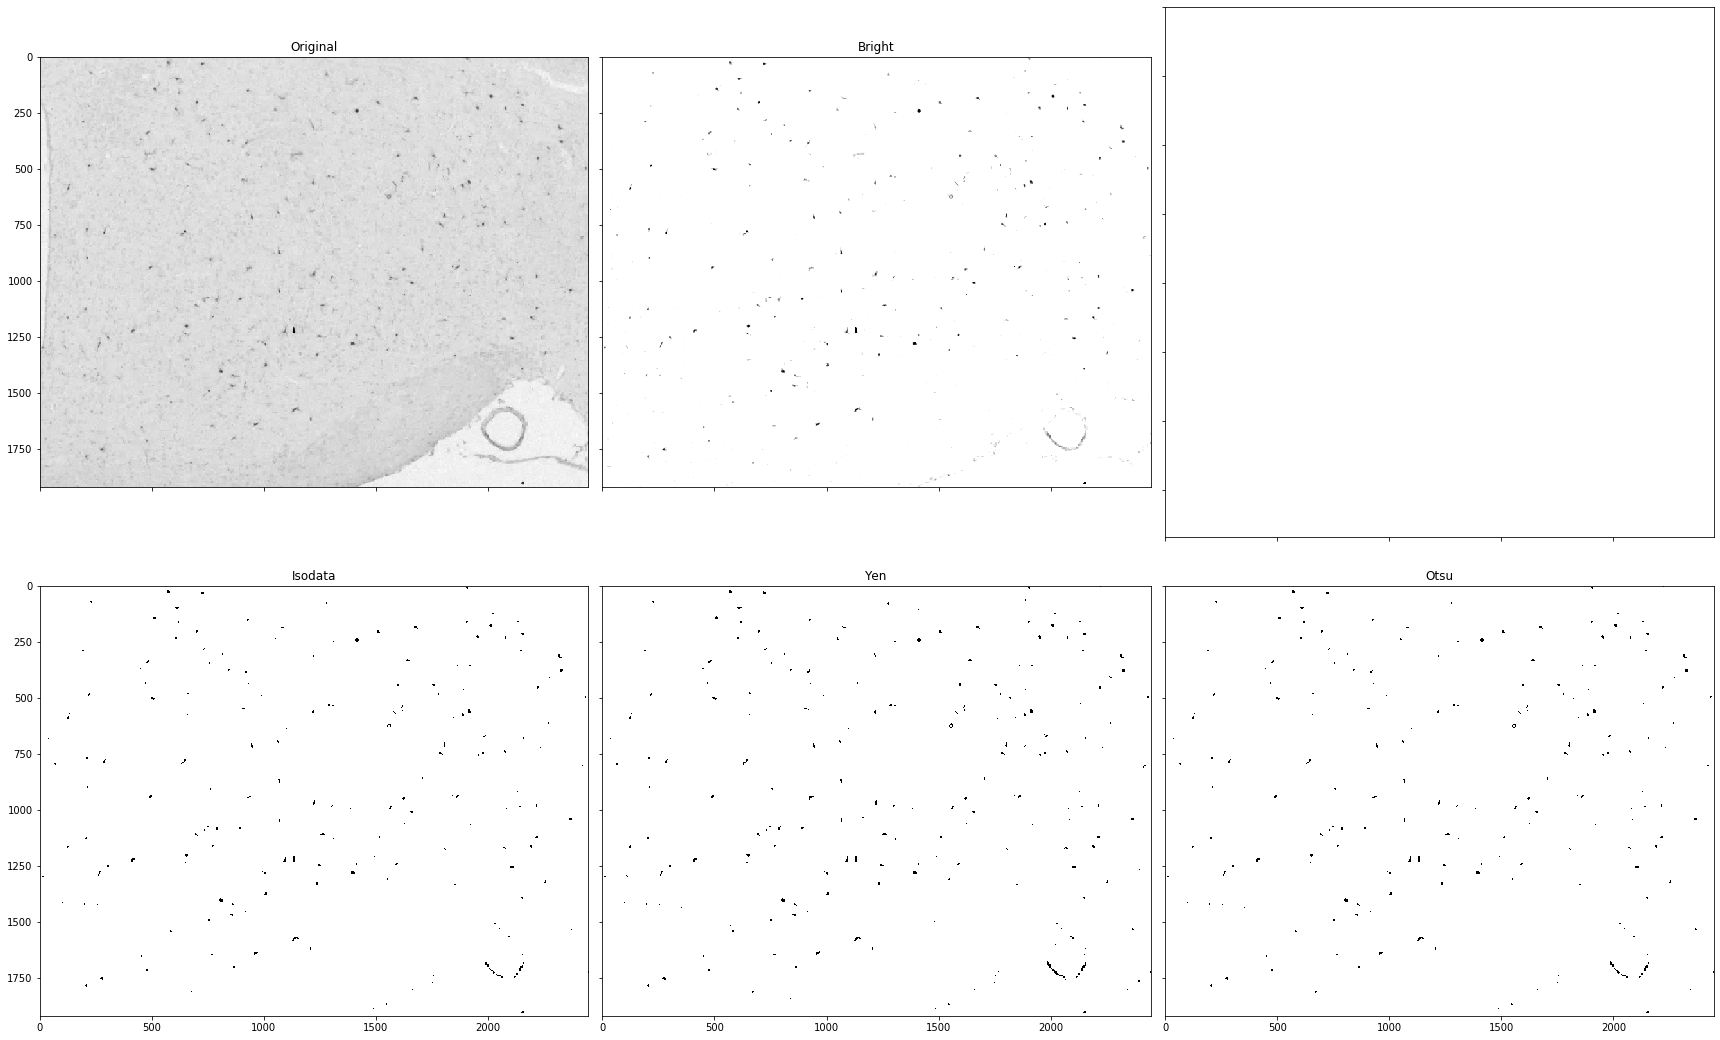

In [12]:
from skimage.filters import threshold_isodata, threshold_yen, threshold_otsu
thresh_iso = threshold_isodata(bright_bayes)
isodata = bright_bayes > thresh_iso

thresh_yen = threshold_yen(bright_bayes)
yen = bright_bayes > thresh_yen

thresh_otsu = threshold_otsu(bright_bayes)
otsu = bright_bayes > thresh_otsu

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0, 0].imshow(grayscale_bayes)
ax[0, 0].set_title(
    'Original'.format(psnr_bayes))
ax[0, 1].imshow(bright_bayes)
ax[0, 1].set_title(
    'Bright'.format(psnr_bayes))
ax[1, 0].imshow(isodata)
ax[1, 0].set_title(
    'Isodata'.format(psnr_bayes))
ax[1, 1].imshow(yen)
ax[1, 1].set_title(
    'Yen'.format(psnr_bayes))
ax[1,2].imshow(otsu)
ax[1,2].set_title('Otsu')
fig.tight_layout()

plt.show()

In [13]:
#define new colormap
colors = [(1,1,1)] + [(random(),random(),random()) for i in range(255)]
new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

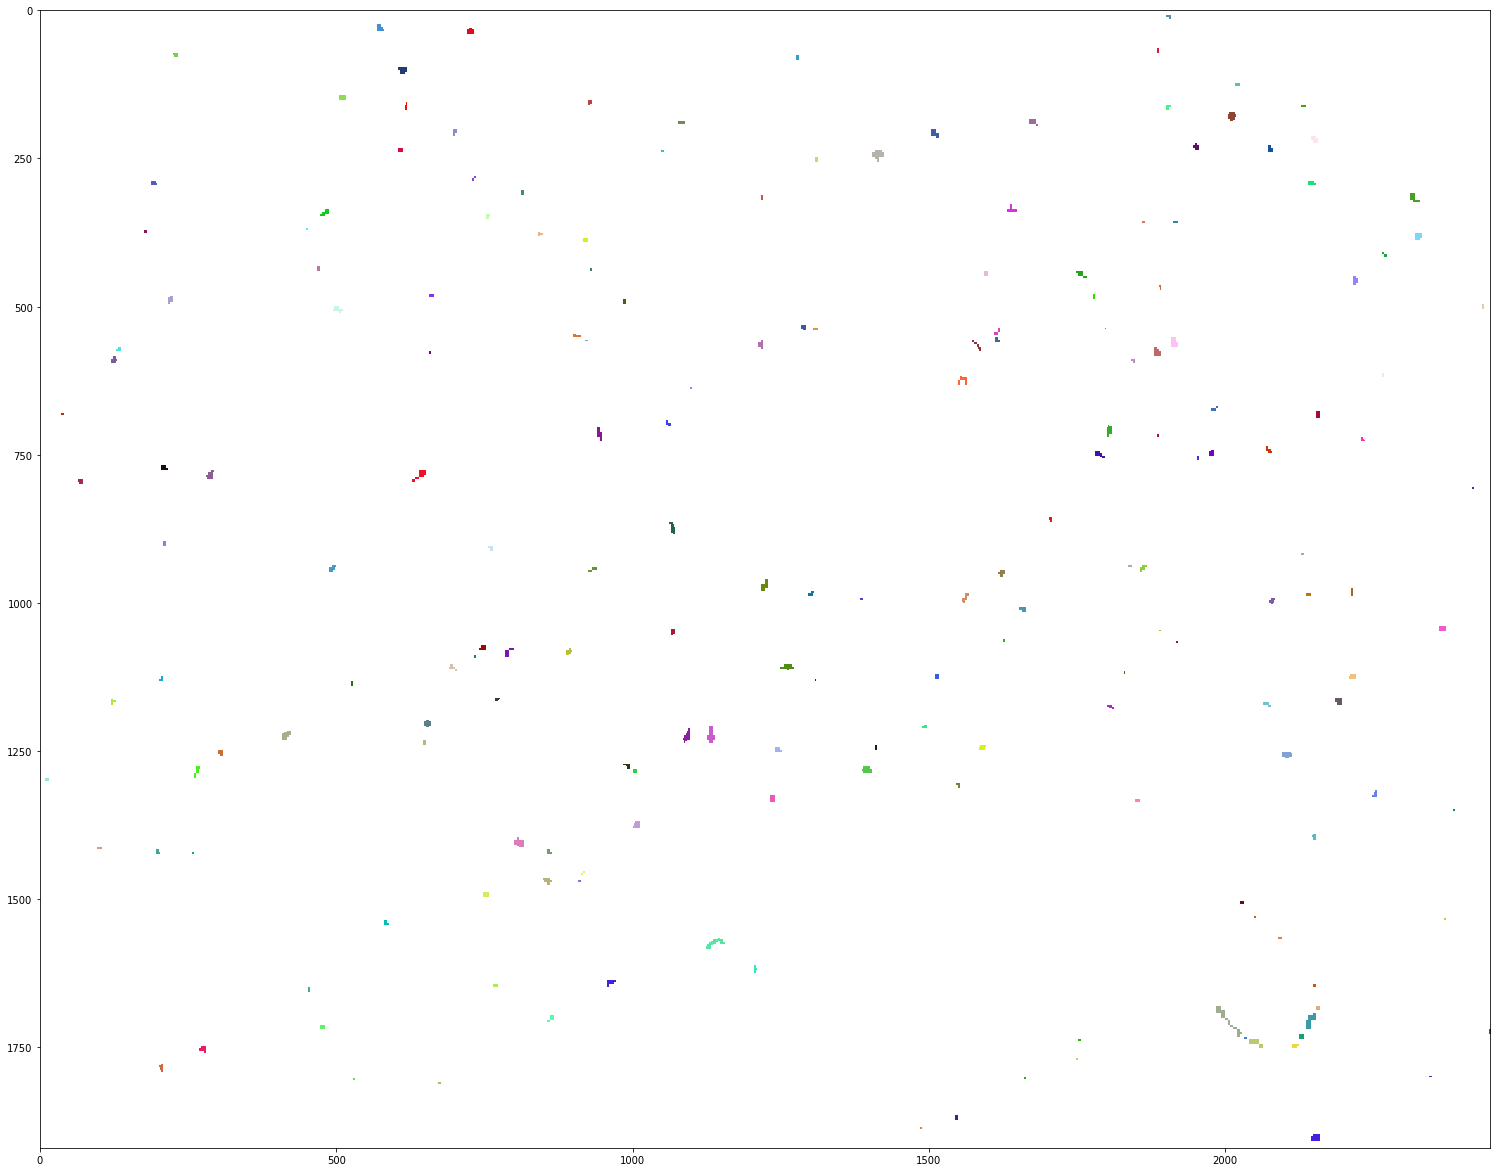

In [14]:
# label image regions
label_image = label(isodata,connectivity=2, background=1)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(26, 26))
ax.imshow(label_image, cmap = new_map)

plt.show()

In [15]:
patches = ndimage.find_objects(label_image)
len(patches)

193

In [16]:
patches_sample = [patches[0], patches[1], patches[2]]
patches_sample

[(slice(8, 16, None), slice(1900, 1908, None)),
 (slice(24, 36, None), slice(568, 580, None)),
 (slice(30, 40, None), slice(720, 732, None))]

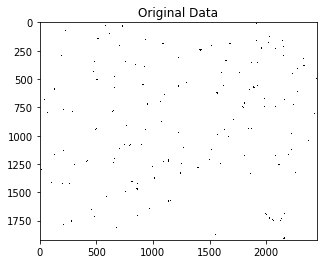

In [17]:
fig, ax = plt.subplots()
ax.imshow(isodata)
ax.set_title('Original Data')

fig, ax = plt.subplots()
ax.imshow(label_image, cmap=new_map)
ax.set_title('Labeled objects')

fig, axes = plt.subplots(ncols=3)
for ax, sli in zip(axes.flat, patches_sample):
    ax.imshow(label_image[sli], cmap = 'gray_r', vmin = 0)
    tpl = 'BBox:\nymin:{0.start}, ymax:{0.stop}\nxmin:{1.start}, xmax:{1.stop}'
    ax.set_title(tpl.format(*sli))
fig.suptitle('Individual Objects')

plt.show()

In [18]:
patch_arrs = []

for i in range(len(patches)):
    patch_arrs.append(np.interp(label_image[patches[i]], 
                                (label_image[patches[i]].min(), label_image[patches[i]].max()), 
                                (0, 1)))

In [19]:
class BBox(object):
    def __init__(self, x1, y1, x2, y2):
        '''
        (x1, y1) is the upper left corner,
        (x2, y2) is the lower right corner,
        with (0, 0) being in the upper left corner.
        '''
        if x1 > x2: x1, x2 = x2, x1
        if y1 > y2: y1, y2 = y2, y1
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

def slice_to_bbox(slices):
    for s in slices:
        dy, dx = s[:2]
        yield BBox(dx.start, dy.start, dx.stop+1, dy.stop+1)

if __name__ == '__main__':
    fig = plt.figure(figsize=(26, 26))
    ax = fig.add_subplot(111)

    data = original
    im = ax.imshow(data)    
    data_slices = patches

    bboxes = slice_to_bbox(data_slices)
    for bbox in bboxes:
        xwidth = bbox.x2 - bbox.x1
        ywidth = bbox.y2 - bbox.y1
        p = mpatches.Rectangle((bbox.x1, bbox.y1), xwidth, ywidth,
                              fc = 'none', ec = 'red')
        ax.add_patch(p)

    plt.show()

In [20]:
df = pd.DataFrame(columns=['solidity', 'orientation', 'diameter', 'area', 'eccentricity', 'convex area', 'major axis length', 
                 'minor axis length', 'extent'])

In [21]:
regions = regionprops(label_image)

for region in regions:
    region_dict = {'solidity': region.solidity,
                   'orientation': region.orientation,
                   'diameter': region.equivalent_diameter,
                   'area': region.area,
                   'eccentricity': region.eccentricity,
                   'convex area': region.convex_area,
                   'major axis length': region.major_axis_length,
                   'minor axis length': region.minor_axis_length,
                   'extent': region.extent}
    df=df.append(region_dict, ignore_index=True)
    
df

solidity  orientation   diameter   area  eccentricity  convex area  \
0    0.888889     0.785398   7.817640   48.0      0.734904         54.0   
1    0.937500     0.595957  12.360774  120.0      0.645910        128.0   
2    0.928571     1.570796  11.507255  104.0      0.633677        112.0   
3    1.000000     0.000000   6.383076   32.0      0.872872         32.0   
4    0.965517     0.619850   8.444016   56.0      0.594207         58.0   
..        ...          ...        ...    ...           ...          ...   
188  1.000000     0.785398   4.513517   16.0      0.000000         16.0   
189  1.000000     0.785398   4.513517   16.0      0.000000         16.0   
190  1.000000     0.000000   6.383076   32.0      0.872872         32.0   
191  1.000000     0.785398   4.513517   16.0      0.000000         16.0   
192  0.967033    -1.307763  14.969641  176.0      0.686105        182.0   

     major axis length  minor axis length    extent  
0            10.263203           6.960204  0.750000  
1            14.638347          11.175117  0.833333  
2            13.324356          10.307692  0.866667  
3             9.165151           4.472136  1.000000  
4             9.689157           7.793105  0.875000  
..                 ...                ...       ...  
188           4.472136           4.472136  1.000000  
189           4.472136           4.472136  1.000000  
190           9.165151           4.472136  1.000000  
191           4.472136           4.472136  1.000000  
192          17.950530          13.059050  0.916667  

[193 rows x 9 columns]

In [22]:
#https://gist.github.com/amueller/3129692
##########################################################################
# Maximum Response filterbank from
# http://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html
# based on several edge and bar filters.
# Adapted to Python by Andreas Mueller amueller@ais.uni-bonn.de
# Share and enjoy
#

import cv2
import pickle

from itertools import product, chain

def makeRFSfilters(radius=28, sigmas=[1, 2, 4], n_orientations=6):
    """ Generates filters for RFS filterbank.
    Parameters
    ----------
    radius : int, default 28
        radius of all filters. Size will be 2 * radius + 1
    sigmas : list of floats, default [1, 2, 4]
        define scales on which the filters will be computed
    n_orientations : int
        number of fractions the half-angle will be divided in
    Returns
    -------
    edge : ndarray (len(sigmas), n_orientations, 2*radius+1, 2*radius+1)
        Contains edge filters on different scales and orientations
    bar : ndarray (len(sigmas), n_orientations, 2*radius+1, 2*radius+1)
        Contains bar filters on different scales and orientations
    rot : ndarray (2, 2*radius+1, 2*radius+1)
        contains two rotation invariant filters, Gaussian and Laplacian of
        Gaussian
    """
    def make_gaussian_filter(x, sigma, order=0):
        if order > 2:
            raise ValueError("Only orders up to 2 are supported")
        # compute unnormalized Gaussian response
        response = np.exp(-x ** 2 / (2. * sigma ** 2))
        if order == 1:
            response = -response * x
        elif order == 2:
            response = response * (x ** 2 - sigma ** 2)
        # normalize
        response /= np.abs(response).sum()
        return response

    def makefilter(scale, phasey, pts, sup):
        gx = make_gaussian_filter(pts[0, :], sigma=3 * scale)
        gy = make_gaussian_filter(pts[1, :], sigma=scale, order=phasey)
        temp = gx*gy
        temp = np.reshape(temp,(gx.shape[0],1))
        #f = (gx * gy).reshape(sup, sup)
        f = np.reshape(temp,(int(sup), int(sup)))
        # normalize
        f /= np.abs(f).sum()
        return f

    support = 2 * radius + 1
    x, y = np.mgrid[-radius:radius + 1, radius:-radius - 1:-1]
    orgpts = np.vstack([x.ravel(), y.ravel()])

    rot, edge, bar = [], [], []
    for sigma in sigmas:
        for orient in range(n_orientations):
            # Not 2pi as filters have symmetry
            angle = np.pi * orient / n_orientations
            c, s = np.cos(angle), np.sin(angle)
            rotpts = np.dot(np.array([[c, -s], [s, c]]), orgpts)
            edge.append(makefilter(sigma, 1, rotpts, support))
            bar.append(makefilter(sigma, 2, rotpts, support))

    print (len(rot), len(bar))
    length = np.sqrt(x ** 2 + y ** 2)
    rot.append(make_gaussian_filter(length, sigma=10))
    rot.append(make_gaussian_filter(length, sigma=10, order=2))

    # reshape rot and edge
    edge = np.asarray(edge)
    edge = edge.reshape(len(sigmas), n_orientations, int(support), int(support))
    bar = np.asarray(bar).reshape(edge.shape)
    rot = np.asarray(rot)[:, np.newaxis, :, :]
    print (edge.shape, bar.shape, rot.shape)
    return edge, bar, rot


def apply_filterbank(img, filterbank):
    from scipy.ndimage import convolve
    result = []
    for battery in filterbank:
        for scale in battery:
            response = []
            for filt in scale:
                response.append(convolve(img, filt))
            max_response = np.max(response, axis=0)
            result.append(max_response)
    return result


if __name__ == "__main__":

    sigmas = [1, 2, 4]
    n_sigmas = len(sigmas)
    n_orientations = 6

    edge, bar, rot = makeRFSfilters(sigmas=sigmas,
            n_orientations=n_orientations)

    n = n_sigmas * n_orientations

    # plot filters
    # 2 is for bar / edge, + 1 for rot
    fig, ax = plt.subplots(n_sigmas * 2 + 1, n_orientations)
    for k, filters in enumerate([bar, edge]):
        for i, j in product(range(n_sigmas), range(n_orientations)):
            row = i + k * n_sigmas
            ax[row, j].imshow(filters[i, j, :, :], cmap=plt.cm.gray)
            ax[row, j].set_xticks(())
            ax[row, j].set_yticks(())
    ax[-1, 0].imshow(rot[0, 0], cmap=plt.cm.gray)
    ax[-1, 0].set_xticks(())
    ax[-1, 0].set_yticks(())
    ax[-1, 1].imshow(rot[1, 0], cmap=plt.cm.gray)
    ax[-1, 1].set_xticks(())
    ax[-1, 1].set_yticks(())
    for i in range(2, n_orientations):
        ax[-1, i].set_visible(False)

    plt.show()

0 18
(3, 6, 57, 57) (3, 6, 57, 57) (2, 1, 57, 57)


In [23]:
filterbank = makeRFSfilters()
top8_arr = []

for patch in patch_arrs:
    top8_arr.append(apply_filterbank(patch, filterbank))

0 18
(3, 6, 57, 57) (3, 6, 57, 57) (2, 1, 57, 57)


In [24]:
df_text = pd.DataFrame(columns=['edge1', 'edge2', 'edge3', 'bar1', 'bar2', 'bar3', 'gauss', 'lap'])

In [25]:
for top8 in top8_arr:
    top8_dict = {'edge1': top8[0],
                 'edge2': top8[1],
                 'edge3': top8[2],
                 'bar1': top8[3],
                 'bar2': top8[4],
                 'bar3': top8[5],
                 'gauss': top8[6],
                 'lap': top8[7]}
    df_text=df_text.append(top8_dict, ignore_index=True)
df_text.head()

edge1  \
0  [[-0.00013715047750080436, -0.0005637657879018...   
1  [[0.0009286640214467585, 0.005296462957239571,...   
2  [[0.13298307066276724, 0.18438977459055964, 0....   
3  [[2.9446729917223982e-08, 4.707935570833403e-0...   
4  [[-0.00036129605617338066, 0.01695429854903879...   

                                               edge2  \
0  [[-0.02080391071551118, 0.009495171761771918, ...   
1  [[0.012375602059355756, 0.041931618241589974, ...   
2  [[0.1038678726129495, 0.10370697487933034, 0.1...   
3  [[0.0002165497541490446, 0.0001366156373560051...   
4  [[-0.009068718239869879, 0.020207470537485946,...   

                                               edge3  \
0  [[-0.0020979581836476275, 0.002090169975971575...   
1  [[0.018064499426888866, 0.04885723125313623, 0...   
2  [[0.037208893620092096, 0.03708659480744195, 0...   
3  [[0.0008710792390768863, 0.0006303978299891589...   
4  [[-0.0013665476299579086, 0.001571728956221766...   

                                                bar1  \
0  [[0.0004855540353506088, 0.008760453192620029,...   
1  [[1.8684949250984355e-05, 3.420866005406566e-0...   
2  [[0.24405354143390784, 0.23210386208774403, 0....   
3  [[-3.461109476381679e-15, -3.461109476381679e-...   
4  [[0.0553624462350549, 0.047079210930137, 0.019...   

                                                bar2  \
0  [[0.10968321320778272, 0.12705022646721043, 0....   
1  [[0.02372098824915006, 0.024823271128640204, 0...   
2  [[0.3352709896729329, 0.33475163425503907, 0.3...   
3  [[0.0006871494652846738, 0.0004335048198364891...   
4  [[0.23042588577512932, 0.12455240038228749, 0....   

                                                bar3  \
0  [[0.23870035687503405, 0.20239620057274876, 0....   
1  [[0.11907780918100136, 0.11903871977126776, 0....   
2  [[0.24312351195170262, 0.2423244095341816, 0.2...   
3  [[0.0036295604398596877, 0.0031932971106353914...   
4  [[0.18015854494742595, 0.14779576515653364, 0....   

                                               gauss  \
0  [[0.7500025348268441, 0.7497027913635234, 0.74...   
1  [[0.8367755862274978, 0.836183920655956, 0.835...   
2  [[0.8640552846407978, 0.8642067111600142, 0.86...   
3  [[0.9983306416218514, 0.9986028419860242, 0.99...   
4  [[0.8749832486646676, 0.8750914115198716, 0.87...   

                                                 lap  
0  [[0.5116190978388725, 0.5093538701127962, 0.50...  
1  [[0.5487147198784704, 0.5521189655133553, 0.55...  
2  [[0.5976096217727428, 0.5985243818494574, 0.59...  
3  [[0.6783723495710862, 0.6786479732097033, 0.67...  
4  [[0.5975261782087851, 0.5977639298995714, 0.59...

In [26]:
df = df.join(df_text)
df

solidity  orientation   diameter   area  eccentricity  convex area  \
0    0.888889     0.785398   7.817640   48.0      0.734904         54.0   
1    0.937500     0.595957  12.360774  120.0      0.645910        128.0   
2    0.928571     1.570796  11.507255  104.0      0.633677        112.0   
3    1.000000     0.000000   6.383076   32.0      0.872872         32.0   
4    0.965517     0.619850   8.444016   56.0      0.594207         58.0   
..        ...          ...        ...    ...           ...          ...   
188  1.000000     0.785398   4.513517   16.0      0.000000         16.0   
189  1.000000     0.785398   4.513517   16.0      0.000000         16.0   
190  1.000000     0.000000   6.383076   32.0      0.872872         32.0   
191  1.000000     0.785398   4.513517   16.0      0.000000         16.0   
192  0.967033    -1.307763  14.969641  176.0      0.686105        182.0   

     major axis length  minor axis length    extent  \
0            10.263203           6.960204  0.750000   
1            14.638347          11.175117  0.833333   
2            13.324356          10.307692  0.866667   
3             9.165151           4.472136  1.000000   
4             9.689157           7.793105  0.875000   
..                 ...                ...       ...   
188           4.472136           4.472136  1.000000   
189           4.472136           4.472136  1.000000   
190           9.165151           4.472136  1.000000   
191           4.472136           4.472136  1.000000   
192          17.950530          13.059050  0.916667   

                                                 edge1  \
0    [[-0.00013715047750080436, -0.0005637657879018...   
1    [[0.0009286640214467585, 0.005296462957239571,...   
2    [[0.13298307066276724, 0.18438977459055964, 0....   
3    [[2.9446729917223982e-08, 4.707935570833403e-0...   
4    [[-0.00036129605617338066, 0.01695429854903879...   
..                                                 ...   
188  [[9.471111151162465e-18, 9.471111151162465e-18...   
189  [[9.471111151162465e-18, 9.471111151162465e-18...   
190  [[9.471111151162465e-18, 9.471111151162465e-18...   
191  [[9.471111151162465e-18, 9.471111151162465e-18...   
192  [[0.03679239878701995, 0.09752335805795227, 0....   

                                                 edge2  \
0    [[-0.02080391071551118, 0.009495171761771918, ...   
1    [[0.012375602059355756, 0.041931618241589974, ...   
2    [[0.1038678726129495, 0.10370697487933034, 0.1...   
3    [[0.0002165497541490446, 0.0001366156373560051...   
4    [[-0.009068718239869879, 0.020207470537485946,...   
..                                                 ...   
188  [[5.21091876916238e-17, 5.21091876916238e-17, ...   
189  [[5.21091876916238e-17, 5.21091876916238e-17, ...   
190  [[5.21091876916238e-17, 5.21091876916238e-17, ...   
191  [[5.21091876916238e-17, 5.21091876916238e-17, ...   
192  [[0.0677937899688079, 0.145113789891626, 0.205...   

                                                 edge3  \
0    [[-0.0020979581836476275, 0.002090169975971575...   
1    [[0.018064499426888866, 0.04885723125313623, 0...   
2    [[0.037208893620092096, 0.03708659480744195, 0...   
3    [[0.0008710792390768863, 0.0006303978299891589...   
4    [[-0.0013665476299579086, 0.001571728956221766...   
..                                                 ...   
188  [[8.046006819465604e-18, 8.046006819465604e-18...   
189  [[8.046006819465604e-18, 8.046006819465604e-18...   
190  [[8.046006819465604e-18, 8.046006819465604e-18...   
191  [[8.046006819465604e-18, 8.046006819465604e-18...   
192  [[0.027925065338194766, 0.05452140149831027, 0...   

                                                  bar1  \
0    [[0.0004855540353506088, 0.008760453192620029,...   
1    [[1.8684949250984355e-05, 3.420866005406566e-0...   
2    [[0.24405354143390784, 0.23210386208774403, 0....   
3    [[-3.461109476381679e-15, -3.461109476381679e-...   
4    [[0.0553624462350549, 0.047079210930137, 0.019...   
..  

In [27]:
hog_arr = []

for patch in patch_arrs:
    hog_arr.append(hog(patch, pixels_per_cell=(4, 4), cells_per_block=(1, 1)))

df['hog'] = hog_arr
df

solidity  orientation   diameter   area  eccentricity  convex area  \
0    0.888889     0.785398   7.817640   48.0      0.734904         54.0   
1    0.937500     0.595957  12.360774  120.0      0.645910        128.0   
2    0.928571     1.570796  11.507255  104.0      0.633677        112.0   
3    1.000000     0.000000   6.383076   32.0      0.872872         32.0   
4    0.965517     0.619850   8.444016   56.0      0.594207         58.0   
..        ...          ...        ...    ...           ...          ...   
188  1.000000     0.785398   4.513517   16.0      0.000000         16.0   
189  1.000000     0.785398   4.513517   16.0      0.000000         16.0   
190  1.000000     0.000000   6.383076   32.0      0.872872         32.0   
191  1.000000     0.785398   4.513517   16.0      0.000000         16.0   
192  0.967033    -1.307763  14.969641  176.0      0.686105        182.0   

     major axis length  minor axis length    extent  \
0            10.263203           6.960204  0.750000   
1            14.638347          11.175117  0.833333   
2            13.324356          10.307692  0.866667   
3             9.165151           4.472136  1.000000   
4             9.689157           7.793105  0.875000   
..                 ...                ...       ...   
188           4.472136           4.472136  1.000000   
189           4.472136           4.472136  1.000000   
190           9.165151           4.472136  1.000000   
191           4.472136           4.472136  1.000000   
192          17.950530          13.059050  0.916667   

                                                 edge1  \
0    [[-0.00013715047750080436, -0.0005637657879018...   
1    [[0.0009286640214467585, 0.005296462957239571,...   
2    [[0.13298307066276724, 0.18438977459055964, 0....   
3    [[2.9446729917223982e-08, 4.707935570833403e-0...   
4    [[-0.00036129605617338066, 0.01695429854903879...   
..                                                 ...   
188  [[9.471111151162465e-18, 9.471111151162465e-18...   
189  [[9.471111151162465e-18, 9.471111151162465e-18...   
190  [[9.471111151162465e-18, 9.471111151162465e-18...   
191  [[9.471111151162465e-18, 9.471111151162465e-18...   
192  [[0.03679239878701995, 0.09752335805795227, 0....   

                                                 edge2  \
0    [[-0.02080391071551118, 0.009495171761771918, ...   
1    [[0.012375602059355756, 0.041931618241589974, ...   
2    [[0.1038678726129495, 0.10370697487933034, 0.1...   
3    [[0.0002165497541490446, 0.0001366156373560051...   
4    [[-0.009068718239869879, 0.020207470537485946,...   
..                                                 ...   
188  [[5.21091876916238e-17, 5.21091876916238e-17, ...   
189  [[5.21091876916238e-17, 5.21091876916238e-17, ...   
190  [[5.21091876916238e-17, 5.21091876916238e-17, ...   
191  [[5.21091876916238e-17, 5.21091876916238e-17, ...   
192  [[0.0677937899688079, 0.145113789891626, 0.205...   

                                                 edge3  \
0    [[-0.0020979581836476275, 0.002090169975971575...   
1    [[0.018064499426888866, 0.04885723125313623, 0...   
2    [[0.037208893620092096, 0.03708659480744195, 0...   
3    [[0.0008710792390768863, 0.0006303978299891589...   
4    [[-0.0013665476299579086, 0.001571728956221766...   
..                                                 ...   
188  [[8.046006819465604e-18, 8.046006819465604e-18...   
189  [[8.046006819465604e-18, 8.046006819465604e-18...   
190  [[8.046006819465604e-18, 8.046006819465604e-18...   
191  [[8.046006819465604e-18, 8.046006819465604e-18...   
192  [[0.027925065338194766, 0.05452140149831027, 0...   

                                                  bar1  \
0    [[0.0004855540353506088, 0.008760453192620029,...   
1    [[1.8684949250984355e-05, 3.420866005406566e-0...   
2    [[0.24405354143390784, 0.23210386208774403, 0....   
3    [[-3.461109476381679e-15, -3.461109476381679e-...   
4    [[0.0553624462350549, 0.047079210930137, 0.019...   
..  

In [35]:
df['label'] = np.zeros(len(patches)).astype(int)
df.head()

solidity  orientation   diameter   area  eccentricity  convex area  \
0  0.888889     0.785398   7.817640   48.0      0.734904         54.0   
1  0.937500     0.595957  12.360774  120.0      0.645910        128.0   
2  0.928571     1.570796  11.507255  104.0      0.633677        112.0   
3  1.000000     0.000000   6.383076   32.0      0.872872         32.0   
4  0.965517     0.619850   8.444016   56.0      0.594207         58.0   

   major axis length  minor axis length    extent  \
0          10.263203           6.960204  0.750000   
1          14.638347          11.175117  0.833333   
2          13.324356          10.307692  0.866667   
3           9.165151           4.472136  1.000000   
4           9.689157           7.793105  0.875000   

                                               edge1  \
0  [[-0.00013715047750080436, -0.0005637657879018...   
1  [[0.0009286640214467585, 0.005296462957239571,...   
2  [[0.13298307066276724, 0.18438977459055964, 0....   
3  [[2.9446729917223982e-08, 4.707935570833403e-0...   
4  [[-0.00036129605617338066, 0.01695429854903879...   

                                               edge2  \
0  [[-0.02080391071551118, 0.009495171761771918, ...   
1  [[0.012375602059355756, 0.041931618241589974, ...   
2  [[0.1038678726129495, 0.10370697487933034, 0.1...   
3  [[0.0002165497541490446, 0.0001366156373560051...   
4  [[-0.009068718239869879, 0.020207470537485946,...   

                                               edge3  \
0  [[-0.0020979581836476275, 0.002090169975971575...   
1  [[0.018064499426888866, 0.04885723125313623, 0...   
2  [[0.037208893620092096, 0.03708659480744195, 0...   
3  [[0.0008710792390768863, 0.0006303978299891589...   
4  [[-0.0013665476299579086, 0.001571728956221766...   

                                                bar1  \
0  [[0.0004855540353506088, 0.008760453192620029,...   
1  [[1.8684949250984355e-05, 3.420866005406566e-0...   
2  [[0.24405354143390784, 0.23210386208774403, 0....   
3  [[-3.461109476381679e-15, -3.461109476381679e-...   
4  [[0.0553624462350549, 0.047079210930137, 0.019...   

                                                bar2  \
0  [[0.10968321320778272, 0.12705022646721043, 0....   
1  [[0.02372098824915006, 0.024823271128640204, 0...   
2  [[0.3352709896729329, 0.33475163425503907, 0.3...   
3  [[0.0006871494652846738, 0.0004335048198364891...   
4  [[0.23042588577512932, 0.12455240038228749, 0....   

                                                bar3  \
0  [[0.23870035687503405, 0.20239620057274876, 0....   
1  [[0.11907780918100136, 0.11903871977126776, 0....   
2  [[0.24312351195170262, 0.2423244095341816, 0.2...   
3  [[0.0036295604398596877, 0.0031932971106353914...   
4  [[0.18015854494742595, 0.14779576515653364, 0....   

                                               gauss  \
0  [[0.7500025348268441, 0.7497027913635234, 0.74...   
1  [[0.8367755862274978, 0.836183920655956, 0.835...   
2  [[0.8640552846407978, 0.8642067111600142, 0.86...   
3  [[0.9983306416218514, 0.9986028419860242, 0.99...   
4  [[0.8749832486646676, 0.8750914115198716, 0.87...   

                                                 lap  \
0  [[0.5116190978388725, 0.5093538701127962, 0.50...   
1  [[0.5487147198784704, 0.5521189655133553, 0.55...   
2  [[0.5976096217727428, 0.5985243818494574, 0.59...   
3  [[0.6783723495710862, 0.6786479732097033, 0.67...   
4  [[0.5975261782087851, 0.5977639298995714, 0.59...   

                                                 hog  label  
0  [0.0, 0.0, 0.0, 0.0, 0.9999999987499999, 0.0, ...      0  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0  
2  [0.4436782575452994, 0.0, 0.6274557984121765, ...      0  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0  
4  [0.0, 0.0, 0.0, 0.0, 0.9999999987499999, 0.0, ...      0

In [ ]:
#NORMALIZE FEATURES

In [ ]:
#LABEL DATA

In [40]:
# train-test split
df_X = df.iloc[:, 0:18]
df_Y = df.iloc[:, 18]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2)

X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

In [ ]:
clf = svm.LinearSVC()

#clf.fit(X_train, y_train)

#Predict the response for test dataset
#y_pred = clf.predict(X_test)

In [ ]:
#this classifier is going to give a prediction for each patch, 
#so to get the total number of positive cells in an image we will need to sum the label values of the patches